ФОРМУЛИРОВКА ЗАДАНИЯ

Задание 1. A/B–тестирование
1.1 Условие

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

1.2 Входные данные

В качестве входных данных Вы имеете 4 csv-файла:

groups.csv - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 
groups_add.csv - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
active_studs.csv - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 
checks.csv - файл с информацией об оплатах пользователей в дни проведения эксперимента. 

ПОНИМАНИЕ ЗАДАНИЯ:
Исходя из условий задания есть следующее понимание задани:

Необходимо провести анализ А/В тестирования, на основе данных эксперимента за определенный промежуток времени по двум группам Контрольная (со старой механикой оплаты) и Тестовой (с новой механикой оплаты), для этого необходимо составить план:

    1. Необходимо собрать данные проведенного эксперимента в один документ из данных эксперимента (стоит заметить что мы приступаем к анализу уже проведенного эксперимента где уже отобрали выборки двух групп из генеральной совокупности и посмотрели как себя ведут пользователи после эксперимента внедрения новой механики оплаты)
    2. Далее необходимо провести предварительный анализ полученных результатов эксперимента и подготовить данные для проверки статистической значимости различий, если таковы есть
    3. Далее необходимо выбрать и посчитать метрики, которые бы отражали изменения за счет внедрения новой механики оплаты
    4. Далее необходимо выдвинуть гипотезу, которая будет проверять эти изменения
    4. Далее необходимо отталкиваясь от метрик и гипотезы выбрать статистические методы для определения статистической значимости различий между группами
    5. На основе результатов применения статистических методов дать ответ какая из механик оплаты наиболее эффективная

///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

ЗАГРУЗКА ДАННЫХ

In [1]:
# загружаем необходимые библиотеки
import requests 
from urllib.parse import urlencode 
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import norm
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
from scipy import stats
from tqdm.auto import tqdm
import pylab 
import statsmodels.api as sm
import pingouin as pg


plt.style.use('ggplot')

In [2]:
# Далее загружаем таблицу с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа), для этого используем Api
# используем api 
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
public_key = 'https://disk.yandex.ru/d/UhyYx41rTt3clQ' 
 
# получаем url 
final_url = base_url + urlencode(dict(public_key=public_key)) 
response = requests.get(final_url) 
download_url = response.json()['href'] 
 
# загружаем файл в df 
download_response = requests.get(download_url) 
groups = pd.read_csv(download_url, sep = ';') 

# отобразим полученный df groups, чтобы посмотреть как загрузились данные
groups

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A
...,...,...
74479,5692459,B
74480,5692572,B
74481,5692865,B
74482,5693667,B


In [ ]:
# Далее загружаем таблицу с пользователями, который прислали спустя 2 дня после передачи данных, для этого используем Api
# используем api 
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
public_key = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ' 
 
# получаем url 
final_url = base_url + urlencode(dict(public_key=public_key)) 
response = requests.get(final_url) 
download_url = response.json()['href'] 
 
# загружаем файл в df 
download_response = requests.get(download_url) 
groups_add = pd.read_csv(download_url) 

# отобразим полученный df groups_add, чтобы посмотреть как загрузились данные
groups_add

In [21]:
# Далее загружаем таблицу с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента, для этого используем Api
# используем api 
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
public_key = 'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ' 
 
# получаем url 
final_url = base_url + urlencode(dict(public_key=public_key)) 
response = requests.get(final_url) 
download_url = response.json()['href'] 
 
# загружаем файл в df 
download_response = requests.get(download_url) 
active_studs = pd.read_csv(download_url) 

# отобразим полученный df active_studs, чтобы посмотреть как загрузились данные
active_studs

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369
...,...
8336,1794344
8337,296883
8338,3598448
8339,3610547


In [22]:
# Далее загружаем таблицу с информацией об оплатах пользователей в дни проведения эксперимента, для этого используем Api
# используем api 
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
public_key = 'https://disk.yandex.ru/d/pH1q-VqcxXjsVA' 
 
# получаем url 
final_url = base_url + urlencode(dict(public_key=public_key)) 
response = requests.get(final_url) 
download_url = response.json()['href'] 
 
# загружаем файл в df 
download_response = requests.get(download_url) 
checks = pd.read_csv(download_url, sep = ';')

# отобразим полученный df checks, чтобы посмотреть как загрузились данные
checks

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0
...,...,...
536,5645737,1900.0
537,5651566,1900.0
538,5662322,1900.0
539,5681918,1900.0


///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

РАЗВЕДОЧНЫЙ АНАЛИЗ ИСХОДНЫХ ДАННЫХ и ПОДГОТОВКА ДАННЫХ ДЛЯ ПРОВЕДЕНИЯ A/B тестирования

АНАЛИЗ ТАБЛИЦЫ С информацией о принадлежности пользователя к контрольной или экспериментальной группе

In [23]:
# выведем первые три строки чтобы посмотреть на данные
groups.head(3)

,id,grp
0,1489,B
1,1627,A
2,1768,B


In [24]:
# выведем информацию по датасету
groups.info()

# как видно из информации в таблице 74484 строки, 2 колонки, без пропущенных значений, типы данных правильные

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74484 entries, 0 to 74483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74484 non-null  int64 
 1   grp     74484 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [25]:
# посмотрим нет ли пробелов в названии колонок, которые в последующем будут нам мешать
groups.columns
# пробелов не обнаружено

Index(['id', 'grp'], dtype='object')

In [26]:
# узнаем нет ли дубликатов строк в данной таблице
groups[groups.duplicated()]
# дублирующих строк не обнаружено

,id,grp


In [27]:
# посмотрим нет ли лишних значений в колонке группы эксперимента и ошибок в названии групп
groups.grp.unique()
# лишних значений нет

array(['B', 'A'], dtype=object)

In [28]:
# посмотрим нет ли сильно выделяющихся значений в id, через статистику колонки id
groups.id.describe()
# аномальных значений не обнаружено

count    7.448400e+04
mean     2.133752e+06
std      1.531423e+06
min      1.489000e+03
25%      9.174980e+05
50%      1.667190e+06
75%      3.322955e+06
max      5.694419e+06
Name: id, dtype: float64

In [29]:
# посмотрим нет ли повторяющихся id пользователя в датасете
groups.id.nunique()
# дублирующихся id не обнаружено, количество уникальных id пользователя (74484) совпадает с количеством строк (74484) 

74484

////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

АНАЛИЗ ТАБЛИЦЫ С пользователями, который прислали спустя 2 дня после передачи данных

In [30]:
# выведем первые три строки чтобы посмотреть на данные
groups_add.head(3)

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B


In [31]:
# выведем информацию по датасету
groups_add.info()
# как видно из информации в таблице 92 строки, 2 колонки, без пропущенных значений, типы данных правильные

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      92 non-null     int64 
 1   grp     92 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.6+ KB


In [32]:
# посмотрим нет ли пробелов в названии колонок, которые в последующем будут нам мешать
groups_add.columns
# пробелов не обнаружено

Index(['id', 'grp'], dtype='object')

In [33]:
# узнаем нет ли дубликатов строк в данной таблице
groups_add[groups_add.duplicated()]
# дублирующих строк не обнаружено

,id,grp


In [34]:
# посмотрим нет ли лишних значений в колонке группы эксперимента и ошибок в названии групп
groups_add.grp.unique()
# лишних значений нет

array(['B', 'A'], dtype=object)

In [35]:
# посмотрим нет ли сильно выделяющихся значений в id, через статистику колонки id
groups_add.id.describe()
# аномальных значений не обнаружено

count    9.200000e+01
mean     2.796406e+07
std      6.141605e+07
min      5.694584e+06
25%      5.712349e+06
50%      5.729634e+06
75%      5.825646e+06
max      2.010677e+08
Name: id, dtype: float64

In [36]:
# посмотрим нет ли повторяющихся id пользователя в датасете
groups_add.id.nunique()
# дублирующихся id не обнаружено, количество уникальных id пользователя (92) совпадает с количеством строк (92) 

92

////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

АНАЛИЗ ТАБЛИЦЫ С информацией о пользователях, которые зашли на платформу в дни проведения эксперимента

In [37]:
# выведем первые три строки чтобы посмотреть на данные
active_studs.head(3)

,student_id
0,581585
1,5723133
2,3276743


In [38]:
# выведем информацию по датасету
active_studs.info()
# как видно из информации в таблице 8341 строки, 1 колонка, без пропущенных значений, тип данных правильный

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB


In [39]:
# посмотрим нет ли пробелов в названии колонки, которая в последующем будет нам мешать
active_studs.columns
# пробелов не обнаружено

Index(['student_id'], dtype='object')

In [40]:
# узнаем нет ли дубликатов строк в данной таблице
active_studs[active_studs.duplicated()]
# дублирующих строк не обнаружено

,student_id


In [41]:
# посмотрим нет ли сильно выделяющихся значений в student_id, через статистику колонки student_id
active_studs.student_id.describe()
# аномальных значений не обнаружено

count    8.341000e+03
mean     2.448547e+06
std      1.564978e+06
min      1.627000e+03
25%      1.118405e+06
50%      2.094192e+06
75%      3.638877e+06
max      5.951797e+06
Name: student_id, dtype: float64

In [42]:
# посмотрим нет ли повторяющихся student_id пользователя в датасете
active_studs.student_id.nunique()
# дублирующихся student_id не обнаружено, количество уникальных student_id пользователя (8341) совпадает с количеством строк (8341) 

8341

////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

АНАЛИЗ ТАБЛИЦЫ С информацией об оплатах пользователей в дни проведения эксперимента

In [43]:
# выведем первые три строки чтобы посмотреть на данные
checks.head(3)

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0


In [44]:
# выведем информацию по датасету
checks.info()
# как видно из информации в таблице 541 строки, 2 колонки, без пропущенных значений, тип данных правильный

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


In [45]:
# посмотрим нет ли пробелов в названии колонки, которая в последующем будет нам мешать
checks.columns
# пробелов не обнаружено

Index(['student_id', 'rev'], dtype='object')

In [46]:
# узнаем нет ли дубликатов строк в данной таблице
checks[checks.duplicated()]
# дублирующих строк не обнаружено

,student_id,rev


In [47]:
# посмотрим нет ли сильно выделяющихся значений в student_id, через статистику колонки student_id
checks.student_id.describe()
# аномальных значений не обнаружено

count    5.410000e+02
mean     2.514772e+06
std      1.726839e+06
min      1.627000e+03
25%      9.871290e+05
50%      2.526021e+06
75%      3.993249e+06
max      5.740903e+06
Name: student_id, dtype: float64

In [48]:
# посмотрим нет ли повторяющихся student_id пользователя в датасете
checks.student_id.nunique()
# дублирующихся student_id не обнаружено, количество уникальных student_id пользователя (541) совпадает с количеством строк (541) 

541

In [49]:
# посмотрим нет ли сильно выделяющихся значений в rev, через статистику колонки rev
checks.rev.describe()
# аномальных значений не обнаружено

count     541.000000
mean     1059.752317
std       762.712359
min       199.000000
25%       290.000000
50%       840.000000
75%      1900.000000
max      4650.000000
Name: rev, dtype: float64

////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

ОБЬЕДИНЕНИЕ и Предварительный анализ

In [50]:
# обьединим две таблицы с информацией о принадлежности пользователя к контрольной или экспериментальной группе, назовем новый датафрейм groups_main
groups_main = groups.append(groups_add, ignore_index = True )
groups_main

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A
...,...,...
74571,200247820,B
74572,201032527,B
74573,201067612,B
74574,201067653,B


In [51]:
# проверим не появилось ли дубликатов id
groups_main.id.nunique()
# дубликатов id не обнаружено, количество id (74576) совпадает с количеством строк (74576) 

74576

In [52]:
# Посмотрим как были распределены пользователи по выборкам  
groups_main.grp.value_counts()

B    59883
A    14693
Name: grp, dtype: int64

Как видно из результата оценки распределения группе Тест (В) отдано в 4 раза больше пользователей чем в группу Контроль(А), это говорит нам о том что выборки в нашем эксперименте есть дисбаланс в распредлении пользователей.

Для проверки гипотезы необходимо соблюдение условий:
    1. Отсутствие влияющих факторов, кроме самого тестируемого изменения (Когда мы хотим сравнить две версии, влиять должно только изменение и никакие другие внешние факторы)
    В Нашем случае мы берем данные предполагая что внешних воздействий на тестируемое изменение не было и условие для проверки гипотезы соблюдается.
    
    2. Репрезентативная оценка
    Репрезентативность — соответствие свойств выборки характеристикам генеральной совокупности, т.е. когда выборка отражает свойства генеральной совокупности.
    В нашем примере можно наблюдать дисбаланс в выборках тест и контроль (смотреть информацию ячейкой выше), говорит о том что нарушается условие репрезентативной оценки. ЭТО ВАЖНОЕ ЗАМЕЧЕНИЕ СТОИТ УЧЕСТЬ, т.к. это критично для проведения честного А/В теста: если есть дисбаланс, то результат эксперимента может объясняться не тем, что у нас хорошая гипотеза, а тем, что нарушается репрезентативность (например, другой покупательской способностью)
    
    3. Точность оценки (За точность оценки отвечают статистические критерии, плотность и количество данных, параметры распределения метрик. Точность влияет на ошибки и качество эксперимента)
    Это условие будет проверено ниже после проведения анализа полученных данных.

In [53]:
# для дальнейшего обьединения поменяем название колонки id в таблице c информацией о принадлежности пользователя к контрольной или экспериментальной группе
groups_main = groups_main.rename(columns={"id": "student_id"})
groups_main

,student_id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A
...,...,...
74571,200247820,B
74572,201032527,B
74573,201067612,B
74574,201067653,B


In [54]:
# Обьединим два датасета с информацией о принадлежности пользователя к контрольной или экспериментальной группе и с  информацией о пользователях, которые зашли на платформу в дни проведения эксперимента, дабы оставить только тех кто участвовал в эксперименте, при обьединении будем использовать left join дабы отсеисть лишних пользователей не участвовших в эксперименте и назовем новый датасет main_df
main_df = active_studs.merge(groups_main, on='student_id', how='left')
main_df
# как видно из результатов обьединения из 74576 пользователей только 8341 зашли на платформу в день эксперимента

,student_id,grp
0,581585,A
1,5723133,A
2,3276743,B
3,4238589,A
4,4475369,B
...,...,...
8336,1794344,B
8337,296883,B
8338,3598448,B
8339,3610547,B


In [55]:
# Посмотрим как распределились участники эксперемента в день проведения эксперимента
main_df.grp.value_counts()

B    6803
A    1538
Name: grp, dtype: int64

Как видно из результатов наблюдается также как и выше дисбаланс в 4 раза пользователей из тестовой группы (6803) больше участвовало в эксперименте чем в контрольной группе (1538). Такое распределение связано с тем, что мы готовы показать изменение большому количеству пользователей. Если бы не стояла задача показать изменение на таком количестве пользователей тестовой группы, то выборке тестовой группы было бы отдано 20% пользователей.

In [56]:
# Обьединим два датасета с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента и с информацией об оплатах пользователей в дни проведения эксперимента,  при обьединении будем использовать left join к таблице main_df дабы добавить данные оплат только тех кто участвовал в эксперименте, новый датасет назовем также main_df
main_df = main_df.merge(checks, on='student_id', how='left')
main_df

,student_id,grp,rev
0,581585,A,NaN
1,5723133,A,NaN
2,3276743,B,NaN
3,4238589,A,NaN
4,4475369,B,NaN
...,...,...,...
8336,1794344,B,NaN
8337,296883,B,NaN
8338,3598448,B,NaN
8339,3610547,B,290.0


В ходе обьединения информации о пользователях, которые зашли на платформу в день теста и выручки по ним можем наблюдать что не все пользователи воспользовались механикой оплаты (Nan значения в колонке выручки rev)

In [57]:
# Проверим не получились ли про обьединении дубликаты строк
main_df[main_df.duplicated()]

,student_id,grp,rev


In [58]:
# посмотрим на статистику конечного датасета
main_df.info()
# как видно из результатов обьединения из 8341 пользователей только 392 оплатили в день эксперимента

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8341 entries, 0 to 8340
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  8341 non-null   int64  
 1   grp         8341 non-null   object 
 2   rev         392 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 260.7+ KB


In [59]:
# посмотрим как распределились пользователи совершившие покупку (использовали механику оплаты) в двух группах
# убираем тех кто не оплачивал
pay_users = main_df.dropna()
pay_users.grp.value_counts()

B    314
A     78
Name: grp, dtype: int64

Как можно наблюдать выше также как и ранее за счет того что в тестовой группе больше пользователей, чем в контрольной наблюдается дисбаланс (также в 4 раза) в пользователях которые платили на платформе

////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

ВЫБОР МЕТРИК

В ходе анализа нашего эксперимента чтобы оценить тестируемое изменение можно провести подсчет метрик, которые бы его отражали. 
Для этого можно задать вопрос : "На какие метрики Вы смотрите в ходе анализа и почему?"
Для ответа на данный вопрос стоит сказать следующее что изменение механики оплаты обычно (исходя из опыта наблюдений) ведет к изменении следующих метрик:

    1. количество повторных покупок на пользователя (ACP) (уменьшается или увеличивается)
    2. средний чек (уменьшается или увеличивается)
    3. Выручка (уменьшается или увеличивается)
    4. ARPPU (средний платеж на платящего пользователя) (уменьшается или увеличивается)
    5. конверсия в покупку (СR) (уменьшается или увеличивается)
    6. ARPU (средний платеж на зарегистрированного) (уменьшается или увеличивается)

Ответом на данный вопрос и будут являться эти метрики

Давайте взглянем как поменялись метрики в тестовой группе по сравнению с контрольной после применения новой механики оплаты:

1. Количество повторных покупок на пользователя (APC)

из предварительного анализа во время подготовки данных было выявлено что в день теста среди пользователей обеих групп не было повторяющихся значений, а это значит что каждый из пользователей обеих груп совершил/не совершил только 1 покупку, то есть данная метрика у нас будет равняться 1 в обеих группах (на пользователя приходится только одна покупка/непокупка)

In [60]:
# Этот факт можно наблюдать если мы посчитаем данную метрику:
# берем таблицу с данными по пользователям совершими покупки подсчитываем количество купивших в каждой группе
pay_users_count = pay_users.groupby('grp', as_index = False).agg({'student_id': pd.Series.nunique})
pay_users_count = pay_users_count.rename(columns={'student_id': 'pay_users_count'})

# берем main_df и подсчитаем количество всех совершенных покупок у пользователей
number_purchases = main_df.dropna()
number_purchases = number_purchases.groupby('grp', as_index = False).agg({'rev': 'count'})

# обьединив обе таблицы считаем метрику количество повторных покупок на пользователя
APC = pay_users_count.merge(number_purchases, how = 'inner', on = 'grp')
APC['APC'] = APC['rev'] / APC['pay_users_count']
APC = APC[['grp', 'APC']]
APC

,grp,APC
0,A,1.0
1,B,1.0


Данная метрика не может в данном случае показать есть ли изменения после применения новой механики оплаты, перейдем к просмотру других метрик 

 2. Cредний чек 

In [61]:
# Посчитаем и сравним как поменялись средние чеки после тестируемого изменения:
# Для этого берем main_df и считаем средний чек по группам
avg_price = main_df.groupby('grp', as_index = False).agg({'rev': 'mean'})
avg_price = avg_price.rename(columns={'rev': 'avg_price'})
avg_price

,grp,avg_price
0,A,933.589744
1,B,1257.878992


Как видно из результатов подсчета данная метрика отражает что изменения есть и после применения новой механики оплаты у тестовой группы увеличился средний чек почти в 1,5 раза

3. Выручка

In [62]:
# Посчитаем и сравним как поменялась выручка после тестируемого изменения:
# Для этого берем main_df и считаем сумму всех чеков по группам
revenue = main_df.groupby('grp', as_index = False).agg({'rev': 'sum'})
revenue = revenue.rename(columns={'rev': 'revenue'})
revenue

,grp,revenue
0,A,72820.0000
1,B,394974.0035


Как видно из результатов подсчета данная метрика отражает что изменения есть и они существенные и после применения новой механики оплаты у тестовой группы увеличилась выручка в 5 раз

4. ARPPU 

In [63]:
# Посчитаем и сравним как поменялся ARPU после тестируемого изменения:
# Для этого берем количество повторных покупок и средний чек по группам и обьединяем
ARPPU = APC.merge(avg_price, how = 'inner', on = 'grp')
# считаем метрику ARPPU
ARPPU['ARPPU'] = ARPPU['avg_price'] * ARPPU['APC']
ARPPU = ARPPU[['grp','ARPPU']]
ARPPU

,grp,ARPPU
0,A,933.589744
1,B,1257.878992


Как видно из результатов подсчета данная метрика отражает что изменения есть и после применения новой механики оплаты у тестовой группы увеличился средний чек почти в 1,5 раза. Данные ARPPU совпадают в данном случае с результатами метрики средний чек так как в ее формуле используется значение повторных покупок равное 1.

5. Конверсия в покупку (CR)

In [64]:
# Посчитаем и сравним как поменялась конверсия в покупку после тестируемого изменения:
# Для этого берем main_df и считаем количество участвующих пользователей в день эксперимента по группам
count_users_exp_day = main_df.groupby('grp', as_index = False).agg({'student_id': pd.Series.nunique})
count_users_exp_day = count_users_exp_day.rename(columns={'student_id': 'count_users_exp_day'})
count_users_exp_day
# Далее обьединяем данные по количеству участвующих пользователей в день эксперимента в каждой группе и данные по количеству купивших в каждой группе (данные посчитаны выше)
CR = count_users_exp_day.merge(pay_users_count, how = 'inner', on = 'grp')
# считаем метрику 
CR['CR'] = (CR['pay_users_count'] / CR['count_users_exp_day'])*100
CR = CR[['grp', 'CR']]
CR

,grp,CR
0,A,5.071521
1,B,4.615611


Как видно из результатов подсчета данная метрика отражает что изменения есть (незначительные) и после применения новой механики оплаты у тестовой группы конверсия немного уменьшилась (примерно на 10% (примерно на -0,46) по сравнению с контрольной)

6. ARPU

In [65]:
# Посчитаем и сравним как поменялся ARPU после тестируемого изменения:
# далее обьединяем данные по выручке и данные по количеству купивших в каждой группе (подсчитали ранее в метрике ACP)
ARPU = ARPPU.merge(CR, how = 'inner', on = 'grp')
# считаем метрику ARPU 
ARPU['ARPU'] = ARPU['ARPPU'] * ARPU['CR']
ARPU = ARPU[['grp', 'ARPU']]
ARPU

,grp,ARPU
0,A,4734.720416
1,B,5805.879810


Как видно из результатов подсчета данная метрика отражает что изменения есть и после применения новой механики оплаты у тестовой группы ARPU или средний платеж на зарегистрированнного пользователя увеличился в 1,2 раза 

ВОПРОС: Имеются ли различия в показателях и с чем они могут быть связаны?

Ответом на данный является краткое резюме полученных данных:
1. Метрика количество повторных покупок на пользователя не показала разницы в использовании новой механики оплаты. Это мб связано с тем что эксперимент проводился малое количество дней (короткий промежуток времени), поэтому за такой промежуток времени клиенты могли не захотеть купить второй раз что- то на нашей платформе.
2. Изменения после применения новой механики оплаты есть, это подтверждается следующими метриками: средний чек, ARPU, ARPPU, выручка, конверсия в покупку. Это можно обьяснить следующими аргументами: возможно имеет место быть то что нарушается репрезентативность (например, другой покупательской способностью) из за дисбаланса в выборках, второй аргумент недостаточность времени проведения эксперимента (например больший срок проведения эксперимента привел бы к большей конверсии в покупку и увеличении ARPPU)

Теперь следует определить есть ли статистически значимые различия между группами, или эти разницы в выборках случайны, для этого выдвинем гипотезу и выберем статистический критерий, которым будет проверены эти различия.

////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

Готовим данные по для проверки различий с помощью статистического критерия

Проводим деление на группы пользователей (A - контрольная, B - тестовая)

In [66]:
# отберем только данные по Контрольной группе и запишем в переменную A
A_group = main_df.query("grp == 'A'")
A_group.head()

,student_id,grp,rev
0,581585,A,NaN
1,5723133,A,NaN
3,4238589,A,NaN
7,1394612,A,NaN
21,5194768,A,NaN


In [67]:
# отберем только данные по Тестовой группе и запишем в переменную B
B_group = main_df.query("grp == 'B'")
B_group.head()

,student_id,grp,rev
2,3276743,B,NaN
4,4475369,B,NaN
5,5481015,B,NaN
6,1353433,B,NaN
8,1170611,B,NaN


Проведем описательную статистику двух групп

In [68]:
A_group.rev.describe()
# посмотрим на описательную статистику выручки в контрольной группе

count      78.000000
mean      933.589744
std       919.932711
min       199.000000
25%       290.000000
50%       585.000000
75%      1114.750000
max      3660.000000
Name: rev, dtype: float64

In [69]:
B_group.rev.describe()
# посмотрим на описательную статистику выручки в тестовой группе

count     314.000000
mean     1257.878992
std       790.864254
min       199.000000
25%       511.750000
50%      1140.000000
75%      1900.000000
max      4650.000000
Name: rev, dtype: float64

In [70]:
print(A_group.rev.sum())
# посчитаем сумму значений метрики в контрольной группе 

print(B_group.rev.sum())
# посчитаем сумму значений метрики в тестовой группе 

72820.0
394974.0035


In [71]:
print(A_group.rev.median())
# посчитаем медиану метрики в контрольной группе 

print(B_group.rev.median())
# посчитаем медиану метрики в тестовой группе 

585.0
1140.0


Посмотрев данные описательной статистики по контрольной и тестовой группе можно сделать следующие выводы:
1. По размеру обе группы неравны: в контрольной группе 1538 пользователей, а в тестовой 6803 пользователя
2. среднее как и медиана в двух группах отличаются:
        в тестовой группе показатели метрики больше чем в контрольной группе: 47.347204 (среднее в контрольной группе), 58.058798 (среднее в тестовой группе), (сумма выручки в тестовой группе почти в 5,5 раз больше чем выручка в контрольной), 585.0 (медиана в контрольной группе), 1140.0 (медиана в контрольной группе)
3. сильно выраженных выбросов не обнаружено

ПРОВЕРКА ВЫБРОСОВ

In [72]:
# Для того чтобы проверить имеются ли выбросы можно построить графики boxplot 

Text(0, 0.5, 'Группа теста')

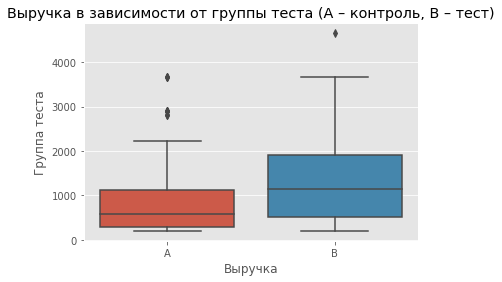

In [73]:
sns.boxplot(data = main_df, x='grp', y = 'rev')
plt.title('Выручка в зависимости от группы теста (A – контроль, B – тест)')
plt.xlabel('Выручка')
plt.ylabel('Группа теста')
# строим боксплот по 2 группам

# при интерпретации данного графика можно сделать вывод что выбросов не обнаружено 
# также можно наблюдать что среднее в тестовой группе не попадает в интервал контрольной группы, а среднее контрольной группы едва едва попадает в интервал

ПРОВЕРКА НА НОРМАЛЬНОСТЬ РАСПРЕДЕЛЕНИЯ ДАННЫХ

Графический способ проверки:

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


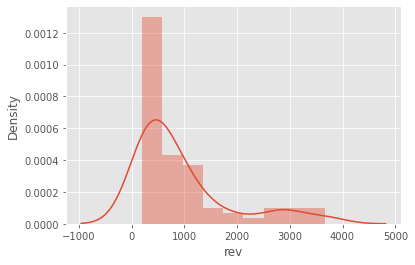

In [74]:
sns.distplot(A_group.rev)
# построим график распределения выручки в контрольной группе


# сравнивая наше распределение (столбики на графике) с идеальной кривой нормального распределения (линия наложенная сверху), можно увидеть следующее
# Где-то есть отклонения чуть выше, чем должно было быть
# Где-то наоборот
# распределение - не Унимодально
# распределение - Ассимметрично
# В целом значение выручки в контрольной группе распределено ненормальным образом

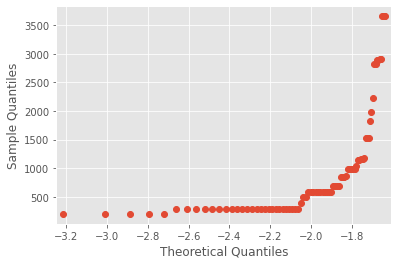

In [75]:
sm.qqplot(A_group.rev)
pylab.show()
# построим график QQ plot для выручки контрольной группы 

# данный график показывает:
#     наши выборочные значения плохо соответствуют предсказанным значениям, если бы наше распределение было идеально нормальным
#     распределение прижато к оси х 
#     Можно утверждать что выборочные значения распределены ненормально

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


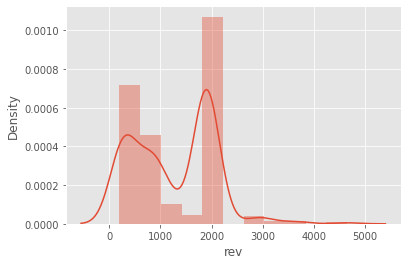

In [76]:
sns.distplot(B_group.rev)
# построим график распределения выручки в тестовой группе

# сравнивая наше распределение (столбики на графике) с идеальной кривой нормального распределения (линия наложенная сверху), можно увидеть следующее
# Где-то есть отклонения чуть выше, чем должно было быть
# Где-то наоборот
# распределение - не Унимодально
# распределение - Ассимметрично
# В целом значение выручки в тестовой группе распределено ненормальным образом

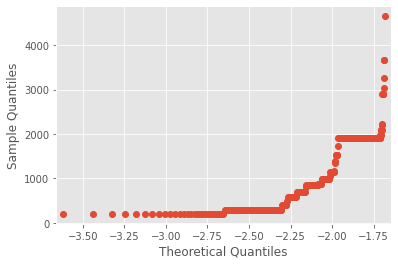

In [77]:
sm.qqplot(B_group.rev)
pylab.show()
# построим график QQ plot для выручки тестовой группы 

# данный график показывает:
#     наши выборочные значения плохо соответствуют предсказанным значениям, если бы наше распределение было идеально нормальным
#     распределение прижато к оси х
#     Можно утверждать что выборочные значения распределены ненормально

Статистические способы проверки нормальности распределения:

In [78]:
# Применяя Тест Шапиро-Уилка проверем гипотезу что данные в группах распределены нормально:
# H0: распределение нормально pvalue > 0.05
# H1: распределение ненормально pvalue < 0.05

# Для проверки на нормальность распредления уберем NaN значения для правильной работы теста
main_df_without_NaN = main_df.dropna()

print(scipy.stats.shapiro(main_df_without_NaN[main_df_without_NaN.grp == 'A'].rev))
# применяем тест Шапиро-Уилка на выручку контрольной группы
# посмотрим как распределены значения в контрольной группе
# значения в контрольной группы распределены ненормально (pvalue=1.4986822893803264e-10 < 0,05)

print(scipy.stats.shapiro(main_df_without_NaN[main_df_without_NaN.grp == 'B'].rev))
# применяем тест Шапиро-Уилка на выручку тестовой группы
# посмотрим как распределены значения в тестовой группе
# значения в тестовой группы распределены ненормально (pvalue=1.5437024585965894e-16 < 0,05)

ShapiroResult(statistic=0.7353236079216003, pvalue=1.4986822893803264e-10)
ShapiroResult(statistic=0.8547235727310181, pvalue=1.5437024585965894e-16)


In [79]:
# Проверим дополнительно тестом Д’Агостино и Пирсона 
print(scipy.stats.normaltest(main_df_without_NaN[main_df_without_NaN.grp == 'A'].rev))
# применяем тест Д’Агостино и Пирсона на выручку контрольной группы
# посмотрим как распределены значения в контрольной группе
# значения в контрольной группы распределены ненормально (pvalue=2.531686880422046e-07 < 0,05)

print(scipy.stats.normaltest(main_df_without_NaN[main_df_without_NaN.grp == 'B'].rev))
# применяем тест Д’Агостино и Пирсона на выручку тестовой группы
# посмотрим как распределены значения в тестовой группе
# значения в тестовой группы распределены ненормально (pvalue=0.033445723194625424 < 0,05)

NormaltestResult(statistic=30.378419638487458, pvalue=2.531686880422046e-07)
NormaltestResult(statistic=6.795662714490353, pvalue=0.033445723194625424)


In [80]:
# Проверим дополнительно данные на нормальность распредления также значений в группах с помощью Pingoin (это статистический пакет Python)
pg.normality(data=main_df_without_NaN, dv="rev", group="grp", method="normaltest")
# в контрольной группе значения распределены ненормально (pvalue=2.531687e-07 < 0,05)
# в контрольной группе значения распределены ненормально (pvalue=3.344572e-02 < 0,05)

,W,pval,normal
A,30.378420,2.531687e-07,False
B,6.795663,3.344572e-02,False


Общий вывод проверки на нормальность распределения данных в 2 группах: при применении графических и статистических способов проверки нормальности распределения данных пришли к выводу что данные в двух группах, имеют распределение отклоняющееся от теоретически нормального

ПРОВЕРКА ГОМОГЕННОСТИ ДИСПЕРСИЙ в ДАННЫХ двух группах

In [81]:
# Проверим отличаются ли дисперсии в наших группах
print(np.var(A_group.rev))
# находим дисперсию внутри контрольной группы
# выведим результат на печать

print(np.var(B_group.rev))
# находим дисперсию внутри тестовой группы
# выведим результат на печать


# Посмотрев на полученные результаты можно дать вывод того что гомогенности дисперсии не выполняется в наших данных дисперсии различаются
# также проверим различия дисперсий с помощью применения критерия Левена

835426.4983563444
623474.3372487942


In [82]:
# С помощью критерия Левена проверим требование гомогенности дисперсий 
stats.levene(main_df_without_NaN[main_df_without_NaN.grp == 'A'].rev, main_df_without_NaN[main_df_without_NaN.grp == 'B'].rev)
# H0: дисперсии равны pvalue > 0.05
# H1: дисперсии не равны pvalue < 0.05

# Результат pvalue=0.08025675761347022 > 0.05
# такой уровень значимость дает основание пологать что дисперсии внутри наших групп все таки равны

LeveneResult(statistic=3.0756816999816055, pvalue=0.08025675761347022)

При проверки гомогенности дисперсии с помощью обычного подсчета с помощью библиотеки numpy были найдены различия, которые с помощью дополнительной проверки с помощью стат теста критерий Левена были опровергнуты

////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

ВЫДВИГАЕМ ГИПОТЕЗУ

Поставленная задача: 
    Перед нами стояла задача стоит ли запускать новую механику оплаты на всех пользователей, для этого посмотрев на метрики которые показали что изменения есть был дан промежуточный итог что он есть, но так ли это на самом деле. Для этого можно выдвинуть гипотезу и проверить статзначимы ли наши различия. 
    Можно поставить следующую гипотезу, которую будем решать статистическими способами:

    H0: среднее в группе контроль - А и тест - В не различаются
    H1: среднее в группе контроль - А и тест - В  различаются
    
    уровень значимости, как пороговое значение отклонения гипотезы пример равным альфа = 0,05
    
   В случае если различия в ходе проверки стат критериями будут найдены (p-value < 0.05) будем предполагать что изменения стат значимы и можно выкатывать новую механику оплаты, в случае отсутствия различий новая механика не будет рекомендоваться к запуску

ПЕРЕХОДИМ К ВЫБОРУ СТАТИСТИЧЕСКОГО КРИТЕРИЯ

In [83]:
print(np.mean(A_group.rev))
# находим среднее значение выручки внутри контрольной группы
# выведим результат на печать

print(np.mean(B_group.rev))
# находим среднее значение выручки внутри тестовой группы
# выведим результат на печать

# На первый взгляд посчитав среднее в контрольной и тестовой группе видно что в тестовой группе среднее выше и можно сделать вывод что в тестовой группе мы стали зарабатывать больше
# но так ли это на самом деле, проверим на примере критериев наши данные

933.5897435897435
1257.8789920382164


Выбор критерия зависит от того сколько у нас групп и как распределены значения метрики:
    1. Так как у нас распределения в обеих группах ненормальные, а дисперсии равны - не выполняются условия для проведения теста критерием t-Стьюдента,  однако зная что на практике t-тест может быть использован для сравнения средних и при ненормальном распределении, особенно на больших выборках и если в данных нет заметных выбросов, можно сделать следующие шаги:
    - Прологарифмировать выборки чтобы привести к виду нормального распределения, после чего сравнить средние через T-test
    - Убрать выбросы (удалить экстремальные значения), после чего сравнить средние через T-test
    - в случае когда два этих способа не помогут можно использовать непараметрические тесты для сравнения средних
   
   Согласно нашим данным наши метрики связаны с деньгами пользователей и отсекать экстремальные значения довольно опасно (такое удаление выбросов может быть нежелательно в силу того что могут отсеяться важные значения по метрике) и выбор тех значений которые нужно отсечь для того чтобы распределения стали нормальными довольно проблематично, мы не будем делать удаление выбросов в данном случае
    2. Также если данные способы не помогут можно воспользоваться бутстрапированием средних и медиан(однако медиана не совсем валидна в данном случае) чтобы дать окончательный вывод по нашему вопросу

Первым делом проведем логарифмирование данных на датасете где удалены NaN значения и посмотрим на распределение (дополнительное замечание - логарифмирование 0 если мы заменим Nan значения неплатящих не даст результата, так как логарифм нуля не определяется)

In [85]:
# проводим логарифмирование
main_df_without_NaN['rev_log'] = np.log(main_df_without_NaN['rev'])

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [86]:
# по статистике колонки с выручкой пользователей посмотрим как прошло логарифмирование
main_df_without_NaN.rev_log.describe()
# логарифмирование прошло удачно

count    392.000000
mean       6.774203
std        0.857472
min        5.293305
25%        5.669881
50%        6.897705
75%        7.549609
max        8.444622
Name: rev_log, dtype: float64

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


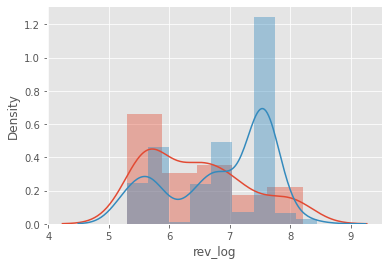

In [87]:
# посмотрим как ведут себя распределения после, отобразим два распределения на одном графике
sns.distplot(main_df_without_NaN[main_df_without_NaN.grp == 'A'].rev_log)
sns.distplot(main_df_without_NaN[main_df_without_NaN.grp == 'B'].rev_log)
# как видно из результатов логарифмирование не дало существенных изменений, распредления также и остались ассиметричными

In [88]:
print(scipy.stats.shapiro(main_df_without_NaN[main_df_without_NaN.grp == 'A'].rev_log))
print(scipy.stats.shapiro(main_df_without_NaN[main_df_without_NaN.grp == 'B'].rev_log))
# применяем тест Шапиро-Уилка на выручку групп снова после логарифмирования
# посмотрим как распределены значения в группах
# в обоих группах значения распределены ненормально (pvalue=2.680935176613275e-05 < 0,05) (pvalue=2.9242029102554055e-17 < 0,05)

ShapiroResult(statistic=0.9057686924934387, pvalue=2.680935176613275e-05)
ShapiroResult(statistic=0.8419413566589355, pvalue=2.9242029102554055e-17)


Как видно из результатов применения логарифмирования не удалось создать условия для проведения проверки статистической значимости с помощью критерия t-Стьюдента. Можно провести проверку на таких распределениях, но тогда мы получим ошибку первого рода (ложноположительное заключение) — так как на самом деле нулевая гипотеза может быть верной, а мы ее отклоняем. Поэтому проводить t-тест Стьюдента мы не будем.

Теперь когда мы узнали что распреления все также ненормально распределены можно обратиться к непараметрическим тестам, одним из таких является U-тест Mann-Whitney. Данный тест проверяет гипотезу о равенстве распределений. Что значит равенство распределений? Это значит, что случайно выбранное значение из одной выборки может быть равновероятно больше или меньше случайного значения из другой выборки (иногда путают с равенством медиан, но на самом деле проверяется не только медиана). Для данного теста не критично нормально ли распредлены значения метрики в выборках, он не удаляет возможно важные значения метрики в обоих группах, а также для него не важно нормально ли распределены значения метрики в обеих группах (а это значит что нет необходимости проводить логарифмирование данных выборок). ОДНАКО есть одно главное замечание проведение проверки статзначимости этим тестом сложно интерпретируется, а так как мы имеем дело с деньгами и результаты данного теста для бизнеса не дадут ничего, т.к. проверяется равенство распределений выборок, поэтому проводить данный тест мы не будем и остановимся на проведении Бутстрапирования выборок на средних.

Применим бутстрап к нашим данным так как он имеет ряд преимуществ:
    1. Бутстрап позволяет строить доверительный интервал для любого параметра распределения, не применяя для этого аналитическую формулу.
    2. Основное преимущество Бутстрапа — возможность проверять гипотезы для любых параметров распределения или модели: перцентилей, квантилей, децилей и т.п.
    3. Бутстрап проверяет статистические гипотезы без опоры на определённое теоретическое распределение данных (в отличие от классических статистических критериев).
    4. Бутстрап позволяет сделать оценку любого «сложного» параметра путём нахождения доверительных интервалов для него. А для проверки гипотез — путём вычисления их разницы.
    

In [94]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа

def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data,
            "quants": quants, 
            "p_value": p_value}

Применяем бутстрап к исходным выборкам с ненормальным распределением, проверяя гипотезу о равенстве средних

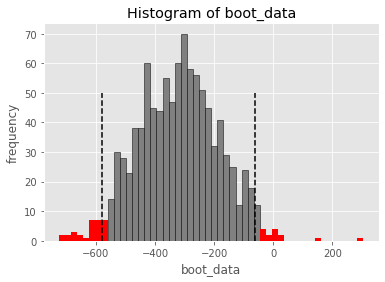

In [96]:
booted_data = get_bootstrap(
    main_df_without_NaN[main_df_without_NaN.grp == 'A'].rev,# числовые значения первой выборки
    main_df_without_NaN[main_df_without_NaN.grp == 'B'].rev, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)
# применяем метод бутстрапа на данные контрольной и тестовой группы, в качестве статистики выберем среднее
# в результате хранится разница двух распределений, Доверительный интервал и p-value

In [97]:
booted_data["p_value"] # выведем p-value

0.018983311269836538

In [98]:
booted_data["quants"] # выведем границы доверительного интервала разниц средних

,0
0.025,-578.446495
0.975,-62.824367


Эмпирическая оценка распределения разниц средних между 2 группами по данным где в выборках ненормальное распределение имеет доверительный интервал смещенный влево от нуля, при уровне значимости p-value = 0.018983311269836538. Cмещение доверительного интервала влево от 0 (0 не попадает в доверительный интервал) дает возможность отклонить нулевую гипотезу что в группах средние равны.

Как было сказано ранее медиана в данном случае не совсем валидна, проведение бутстрапа медиан проводить не будем.

ИТОГОВЫЙ ВЫВОД:

   Перед нами стояла задача стоит ли запускать новую механику оплаты на всех пользователей, для этого посмотрев на метрики которые показали что изменения есть был дан промежуточный итог что они есть. Далее попытавшись привезти данные к условиям для проведения T-теста Сьюдента пришли к тому что распределения также ненормально распределены, сделав вывод о том что при проведении проверки этим критерием мы получим ошибку первого рода было решено не проводить данный тест и оценив другие возможные варианты (бутстрап медиан и использование непараметрического теста Манна Уитни), было решено проводить бутстрапирование средних.
   
   В ходе проверки различия было подтверждено что средние отличаются в обоих группах, а это говорит нам о том что изменения в ходе применения новой механики имееют стат значимость и изменения в выборках не случайны, и можно запустить новую механику оплаты на всех пользователей.